In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.utils import Bunch

%matplotlib inline


In [29]:
def render_hog(hog_descriptor, image_size, cell_size, img_gray, num_bins):
    cells_x = image_size[0] // cell_size[0]
    cells_y = image_size[1] // cell_size[1]

    hog_descriptor_reshaped = hog_descriptor\
        .reshape(cells_y-1, cells_x-1, 2, 2, 9)\
        .transpose((1, 0, 2, 3, 4))

    # Create an array that will hold the average gradients for each cell
    ave_grad = np.zeros((cells_y, cells_x, 9))

    # Create an array that will count the number of histograms per cell
    hist_counter = np.zeros((cells_y, cells_x, 1))

    # Add up all the histograms for each cell and count the number of histograms per cell
    for i in range(2):
        for j in range(2):
            ave_grad[i:(cells_y-1) + i, j:(cells_x-1) + j] += hog_descriptor_reshaped[:, :, i, j, :]
            hist_counter[i:(cells_y-1) + i, j:(cells_x-1) + j] += 1

    # Calculate the average gradient for each cell
    ave_grad /= hist_counter

    # Calculate the total number of vectors we have in all the cells.
    len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

    # Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
    deg = np.linspace(0, np.pi, num_bins, endpoint=False)

    # Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
    # equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
    # To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
    # image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
    # cells in the image. Create the arrays that will hold all the vector positons and components.
    U = np.zeros((len_vecs))
    V = np.zeros((len_vecs))
    X = np.zeros((len_vecs))
    Y = np.zeros((len_vecs))

    # Set the counter to zero
    counter = 0

    # Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
    # cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
    # average gradient array
    for i in range(ave_grad.shape[0]):
        for j in range(ave_grad.shape[1]):
            for k in range(ave_grad.shape[2]):
                U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
                V[counter] = ave_grad[i, j, k] * np.sin(deg[k])

                X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
                Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)

                counter = counter + 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image
    ax1.set(title='Grayscale Image')
    ax1.imshow(img_gray, cmap='gray')

    # Plot the feature vector (HOG Descriptor)
    ax2.set(title='HOG Descriptor')
    ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
    ax2.invert_yaxis()
    ax2.set_aspect(aspect=1)
    ax2.set_facecolor('black')

In [25]:
import cv2


def crop_center(img):
  width, height = img.shape[1], img.shape[0]
  crop_width = min(img.shape[0], img.shape[1])
  crop_height = min(img.shape[0], img.shape[1])
  mid_x, mid_y = int(width/2), int(height/2)
  cw2, ch2 = int(crop_width/2), int(crop_height/2) 
  crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
  return crop_img


def crop_image(raw_image, dimension):
    x = raw_image.shape[1]/2 - dimension[1]/2
    y = raw_image.shape[0]/2 - dimension[0]/2
    return raw_image[int(y):int(y+dimension[0]), int(x):int(x+dimension[1])]


def load_image_files(images_dir_path, dimension=(224, 224), test_split_size=0.2):
    win_size = dimension
    cell_size = (dimension[0]//8, dimension[1]//8)
    block_size = (dimension[0]//4, dimension[1]//4)
    block_stride = (dimension[0]//8, dimension[1]//8)
    num_bins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
    
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []
    test_data = []

    for class_index, directory in enumerate(directories):
        if not directory.is_dir():
            continue

        class_images_cnt = 0
        for file in directory.iterdir():
            class_images_cnt += 1

        for i, file in enumerate(directory.iterdir()):
            image = cv2.imread(file.as_posix(), cv2.IMREAD_COLOR)
            if image is None:
                continue

            if image.shape[0] == 0 or image.shape[1] == 0:
                continue

            image = crop_center(image)
            image = cv2.resize(image, dimension)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            hog_descriptor = hog.compute(image_gray)

            bunch = Bunch(
                image=image,
                image_resized=image,
                image_gray=image_gray,
                hog_descriptor=hog_descriptor,
                class_index=class_index,
                class_name=classes[class_index],
            )

            if i < int(class_images_cnt * test_split_size):
                test_data.append(bunch)
                continue

            train_data.append(bunch)

    return (train_data, test_data)

In [26]:
# train_dataset, test_dataset = load_image_files("groceries", dimension=(224, 224))
# img_shape = (224, 224, 3)
# num_classes = 25

# train_dataset, test_dataset = load_image_files("cifar-10", dimension=(32, 32))
# img_shape = (32, 32, 3)
# num_classes = 10

train_dataset, test_dataset = load_image_files("PetImages", dimension=(160, 160))
img_shape = (160, 160, 3)
num_classes = 2

print(len(train_dataset))
print(len(test_dataset))

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


19953
4993


In [27]:
import random
%matplotlib inline

sample_image_index = random.randint(0, len(train_dataset))

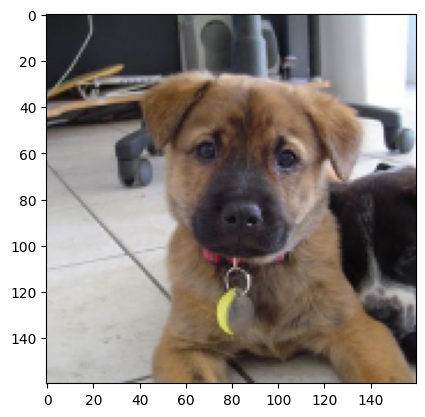

In [28]:

plt.imshow(train_dataset[sample_image_index].image)
plt.show()

In [16]:
render_hog(train_dataset[sample_image_index].hog_descriptor, img_shape, (8, 8), train_dataset[sample_image_index].image_gray, 9 )

NameError: name 'render_hog' is not defined

In [29]:
x_train = np.asarray(list(map(lambda train_bunch: train_bunch.hog_descriptor, train_dataset)))
x_test = np.asarray(list(map(lambda test_bunch: test_bunch.hog_descriptor, test_dataset)))
y_train = np.asarray(list(map(lambda train_bunch: train_bunch.class_index, train_dataset)))
y_test = np.asarray(list(map(lambda test_bunch: test_bunch.class_index, test_dataset)))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(19953, 1764)
(4993, 1764)
(19953,)
(4993,)


In [30]:
import cv2

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 500, 1e-6))
svm.train(x_train.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train)

True

In [31]:
y_pred = svm.predict(x_test.astype(np.float32))[1]

In [32]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2498
           1       0.63      0.64      0.63      2495

    accuracy                           0.63      4993
   macro avg       0.63      0.63      0.63      4993
weighted avg       0.63      0.63      0.63      4993



In [33]:
# svm.save("new_models/hog_svm_cifar10_32x32_f32.dat")
# svm.save("new_models/hog_svm_groceries_224x224_f32.dat")
svm.save("new_models/hog_svm_petimages_150x150_f32.dat")

In [34]:
# svm = cv2.ml.SVM_load("new_models/hog_svm_cifar10_32x32_f32.dat")
# svm = cv2.ml.SVM_load("new_models/hog_svm_groceries_224x224_f32.dat")
svm = cv2.ml.SVM_load("new_models/hog_svm_petimages_150x150_f32.dat")
svm.predict(x_test.astype(np.float32))

(0.0,
 array([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]], dtype=float32))